In [3]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import sparse
import pyLDAvis.gensim
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

/home/misha/environments/my_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/misha/environments/my_env/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [4]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

/home/misha/environments/my_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
 # Целевой признак - число рекомендаций (лайков) статьи, 
    # приведенные в статье значения - логарифм с единицей
    # от числа рекомендаций
path_to_train = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/train.json'
path_to_data = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/'


/home/misha/environments/my_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
with open(path_to_train) as input_json:
    first_line = input_json.readline()
    article_data_json = json.loads(first_line)

In [7]:
article_data_json.keys()

dict_keys(['_id', '_timestamp', '_spider', 'url', 'domain', 'published', 'title', 'content', 'author', 'image_url', 'tags', 'link_tags', 'meta_tags'])

#### Убираем HTML-теги

In [8]:
# для обучающей выборки:
with open(os.path.join(path_to_data, 'train.json')) as input_json_file,\
open (os.path.join(path_to_data, 'train_raw_content.txt'), 'w') \
as out_raw_text_file:
    # считываем данные из обучающей выборки train.json
    # удаляем html-теги, пишем результат в train_raw_content
    # построковое чтение json-файла
    for i in tqdm_notebook(input_json_file):
        json_data = json.loads(i)
        
        # заменяем переводы каретки на пробелы
        content = json_data['content'].replace('\n', ' ')
        
        # убираем html-теги
        content_no_html = strip_tags(content)
        
        # записываем полученный текст в файл
        out_raw_text_file.write(content_no_html + "\n")

<ipython-input-8-f38b012a45b5>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(input_json_file):


In [9]:
# для тестовой выборки:
with open(os.path.join(path_to_data, 'test.json')) as input_json_file,\
open (os.path.join(path_to_data, 'test_raw_content.txt'), 'w') \
as out_raw_text_file:
    # считываем данные из обучающей выборки test.json
    # удаляем html-теги, пишем результат в test_raw_content
    # построковое чтение json-файла
    for i in tqdm_notebook(input_json_file):
        json_data = json.loads(i)
        content = json_data['content'].replace('\n', ' ')
        content_no_html = strip_tags(content)
        out_raw_text_file.write(content_no_html + "\n")

<ipython-input-9-469f82e4e461>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(input_json_file):


In [10]:
!head $path_to_data'train_raw_content.txt'

MediumEveryone’s stories and ideasAug 13, 2012Medium Terms of ServiceEffective: March 7, 2016These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”).By using Medium, you agree to these Terms. If you don’t agree to any of the Terms, you can’t use Medium.We can change these Terms at any time. We keep a historical record of all changes to our Terms on GitHub. If a change is material, we’ll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don’t agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms.Content rights & responsibilitiesYou own the rights to the content you create and post on Medium.By posting content to Medium, you give us a nonexclusive license to publish it on Medium Services, including a

In [33]:
!wc -l $path_to_data/train_raw_content.txt
!wc -l $path_to_data/test_raw_content.txt

62313 /home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle//train_raw_content.txt
34645 /home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle//test_raw_content.txt


#### Конвертируем набор текста в матрицу признаков

In [13]:
# Конвертируем набор текста в матрицу токенов
# Ограничим число признаков 100000
cv = CountVectorizer(max_features=50000)

In [14]:
%%time
# подаем на вход ему файлы train\test_raw_content.txt

with open(os.path.join(path_to_data,
                       'train_raw_content.txt')) as input_train_file:
    X_train = cv.fit_transform(input_train_file)


CPU times: user 1min 17s, sys: 1.99 s, total: 1min 19s
Wall time: 1min 19s


In [15]:
X_train.shape

(62313, 50000)

In [16]:
%%time
# подаем на вход ему файлы train\test_raw_content.txt

with open(os.path.join(path_to_data,
                       'test_raw_content.txt')) as input_test_file:
    X_test = cv.fit_transform(input_test_file)


CPU times: user 39.3 s, sys: 596 ms, total: 39.9 s
Wall time: 39.9 s


In [17]:
X_test.shape

(34645, 50000)

#### Считываем метки (кол-во рекомендаций)

In [18]:
y_train = pd.read_csv(os.path.join(path_to_data, 'train_log1p_recommends.csv'), index_col='id')
y_test = pd.read_csv(os.path.join(path_to_data, 'test_log1p_recommends.csv'), index_col='id')
y_train = y_train['log_recommends'].values
y_test = y_test['log_recommends'].values

#### Построим распределение целевой переменной

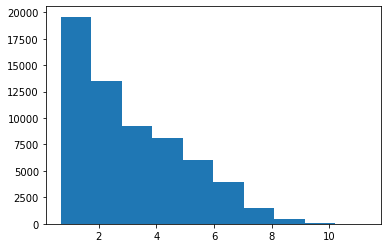

In [19]:
plt.hist(y_train);

In [20]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, train_size=0.7)

In [21]:
?train_test_split

#### Обучим Ridge-регрессию на данных

In [22]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=17)

In [23]:
X_tr.shape, y_tr.shape

((43619, 50000), (43619,))

In [24]:
%%time 
ridge_model.fit(X_tr, y_tr)

CPU times: user 1h 26min 34s, sys: 3h 2min 52s, total: 4h 29min 27s
Wall time: 40min 11s


Ridge(random_state=17)

In [25]:
ridge_07test_pred = ridge_model.predict(X_te)

In [26]:
mean_absolute_error(y_te, ridge_07test_pred)

3.6335372159130768

#### Обучаемся и делаем прогноз на тестовой выборке

In [27]:
%%time
ridge_model.fit(X_train, y_train)
ridge_test_pred = ridge_model.predict(X_test)

CPU times: user 13min 50s, sys: 30min 6s, total: 43min 56s
Wall time: 5min 49s


In [32]:
print([np.log1p(i) for i in ridge_test_pred])

[nan, nan, nan, nan, nan, 0.8379862397797117, 0.5967609649787444, nan, nan, 0.8672510597756713, 1.8905619659404351, nan, 3.7449993926227885, 2.1210081524015947, 3.120627259963282, nan, nan, nan, nan, nan, 2.028051697577353, 3.0056771400226356, nan, nan, nan, nan, 1.404702488215214, -0.33435899444716455, -0.1180096937275075, nan, 1.6122928376081525, -0.39517174701526947, nan, nan, 1.9923848610222739, -0.510685581965054, 0.46081351753377037, nan, 2.547209256092945, 1.9484589802344452, nan, nan, nan, nan, nan, nan, nan, -0.19403748176828375, -4.249204145018867, nan, 2.1470782643904043, nan, 1.5052405628500536, nan, 1.9069303200942824, nan, nan, nan, nan, 2.09800187611485, nan, 0.7785307642373036, 2.1302767102522786, 1.8837222752024376, nan, 1.7007418351483137, nan, 1.2251904105980054, nan, nan, 1.5894223539491612, nan, nan, nan, nan, 3.0638674434787765, nan, nan, nan, nan, nan, nan, 1.344504266434259, 2.1192290740975235, 1.4898759955882408, 1.057139690502941, 0.8387257962865768, nan, 0.15

<ipython-input-32-dfa8b55764d9>:1: RuntimeWarning: invalid value encountered in log1p
  print([np.log1p(i) for i in ridge_test_pred])


In [1]:
def write_submission(pred, filename, path_to_sample=os.path.join(path_to_data, 'sample_submission.csv')):
    sub = pd.read_csv(path_to_sample, index_col='id')
    sub['log_recommends'] = pred
    sub.to_csv(filename)

NameError: name 'os' is not defined

In [2]:
write_submission(ridge_test_pred, os.path.join(path_to_data, 'first_ridge.csv'))

NameError: name 'write_submission' is not defined